# Explainable recommendation
## Attentive Multitask Collaborative Filtering (AMCF) model

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils_amcf import get_data, item_to_genre


In [2]:
# load model
model = torch.load('AMCF_model_13f_20181231.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

AMCF(
  (user_emb): Embedding(73189, 128)
  (item_emb): Embedding(2258, 128)
  (asp_emb): Aspect_emb()
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=13, bias=True)
  )
  (pdist): PairwiseDistance()
)

In [3]:
# get user overall preference of each aspects
users = torch.tensor(range(943), dtype=torch.long).to(device)
u_pred = model.predict_pref(users)
print(u_pred, u_pred.shape)

tensor([[ 0.0618,  0.0131, -0.1073,  ...,  0.0963,  0.2382,  0.0179],
        [ 0.0051, -0.1884, -0.1222,  ..., -0.0815, -0.1437, -0.0287],
        [-0.0008, -0.0167, -0.1261,  ..., -0.2215, -0.3555,  0.0521],
        ...,
        [ 0.0558,  0.0362,  0.1218,  ...,  0.0120,  0.1984,  0.1504],
        [-0.0076, -0.1082,  0.0805,  ..., -0.0381, -0.1283, -0.1300],
        [-0.0349,  0.1834,  0.1285,  ...,  0.2594,  0.0153, -0.0505]],
       device='cuda:0', grad_fn=<DivBackward0>) torch.Size([943, 13])


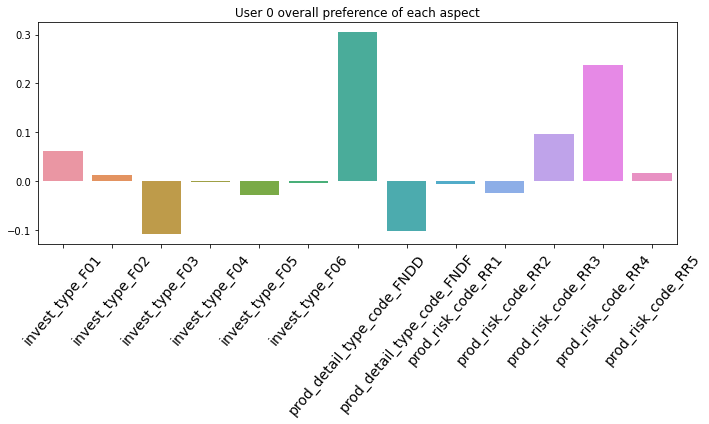

In [4]:
def plot_upref(uid, u_pred):
    df = pd.DataFrame(u_pred[0].cpu().detach().numpy())
    aspects = ['wm_prod_code', 'invest_type_F01', 'invest_type_F02', 'invest_type_F03',
       'invest_type_F04', 'invest_type_F05', 'invest_type_F06',
       'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5']
    plt.figure(figsize=(10,6))
    sns.barplot(x=aspects[1:], y=u_pred[uid].cpu().detach().numpy(), data=df)
    plt.title('User '+str(uid)+' overall preference of each aspect')
    plt.xticks(rotation=50, fontsize=14)
    plt.tight_layout()
    plt.savefig('overall_pref_bar.png')

plot_upref(0, u_pred)

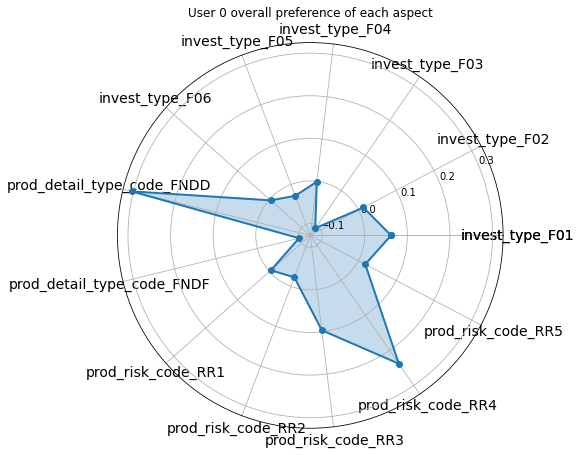

In [5]:
def plot_upref_radar(uid, u_pred):
    stats = u_pred[uid].cpu().detach().numpy()
    aspects = np.array(['invest_type_F01', 'invest_type_F02', 'invest_type_F03',
       'invest_type_F04', 'invest_type_F05', 'invest_type_F06',
       'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5'])
    
    angles=np.linspace(0, 2*np.pi, len(aspects), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    aspects=np.concatenate((aspects,[aspects[0]]))
    ax.set_thetagrids(angles * 180/np.pi, aspects, fontsize=14)
    ax.set_title('User '+str(uid)+' overall preference of each aspect')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig('overall_pref_radar.png')

plot_upref_radar(0, u_pred)

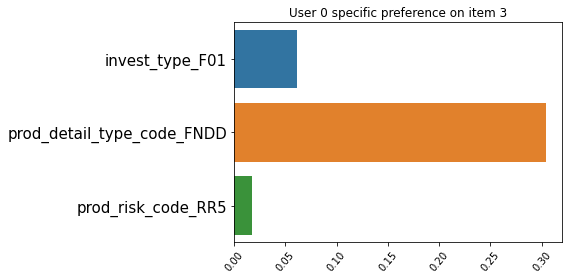

In [74]:
import pickle
fund = pickle.load(open('fund_data_1231.pkl', 'rb'))

def plot_ui_spec_pref(uid, iid, u_pred):
    # get user specific preference on item j of each aspects
    df = pd.DataFrame(u_pred[uid].cpu().detach().numpy())

    aspects = np.array(['invest_type_F01', 'invest_type_F02', 'invest_type_F03',
       'invest_type_F04', 'invest_type_F05', 'invest_type_F06',
       'prod_detail_type_code_FNDD', 'prod_detail_type_code_FNDF',
       'prod_risk_code_RR1', 'prod_risk_code_RR2', 'prod_risk_code_RR3',
       'prod_risk_code_RR4', 'prod_risk_code_RR5'])

    item_feature = np.array(fund[fund['fid']==iid])[0] # multi-hot value
    item_feature = list(item_feature[1:4]) + [0] + list(item_feature[4:])

    spec_pref = u_pred[uid].cpu().detach().numpy()*item_feature
    spec_pref = (spec_pref[spec_pref>0])

    plt.figure(figsize=(8,4))
    # sns.barplot(x=spec_pref, y=aspects, orient='h') # y=aspects
    sns.barplot(x=spec_pref, y=aspects[[0, 6, 12]], orient='h') # y=aspects
    plt.title('User '+str(uid)+' specific preference on item '+str(iid))
    plt.xticks(rotation=50)
    plt.yticks(fontsize=15)
    # plt.axhline(0, color='gray')
    plt.tight_layout()
    # plt.savefig('spec_pref.png')


plot_ui_spec_pref(0, 3, u_pred)